In [10]:
import tensorflow as tf

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [12]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import neattext.functions as nfx
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Embedding,Dense,LSTM,GlobalMaxPooling1D,Input,Dropout,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD,Adam
from tqdm import tqdm

In [13]:
data=pd.read_csv('Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [14]:
data['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

In [15]:
data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [16]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

In [17]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

# **Data Visualisation**

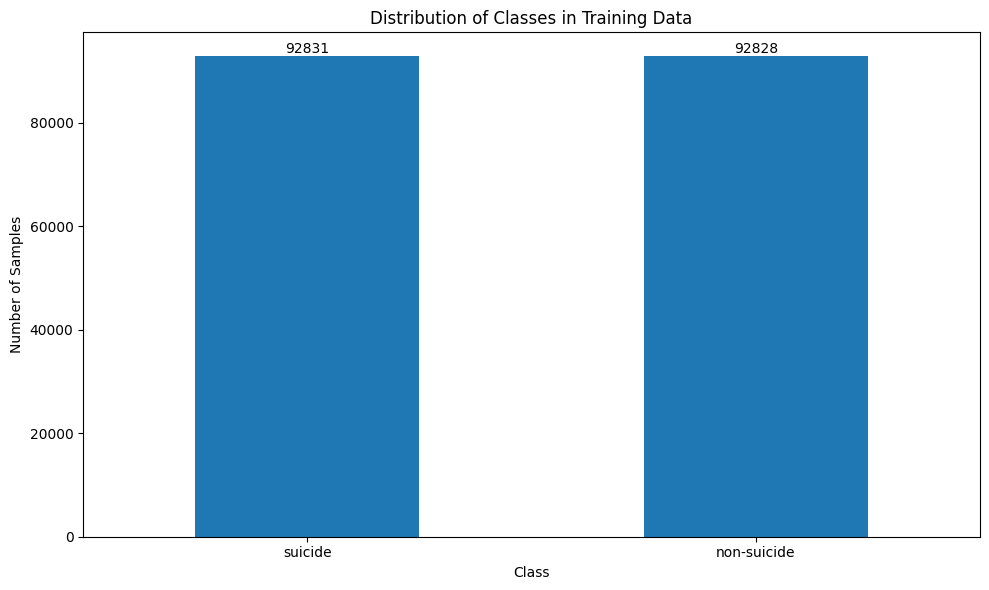

In [18]:
import matplotlib.pyplot as plt

# Get the class counts
class_counts = train_data['class'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)

# Add value labels on top of each bar
for i, v in enumerate(class_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

# **Data Cleaning**

In [ ]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [ ]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [ ]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=100)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=100)

In [ ]:
train_text_pad

# **Glove Embeddings**

In [ ]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [ ]:

import numpy as np

def load_glove_model(file_path):
    print("Loading Glove Model")
    glove_model = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

# Load the GloVe model
glove_file = 'glove.twitter.27B.200d.txt'  # Replace with your GloVe file path
glove_embedding = load_glove_model(glove_file)

# Create the embedding matrix
v = len(tokenizer.word_index)
embedding_dim = 200  # Dimension of GloVe vectors, adjust if using a different dimension

embedding_matrix = np.zeros((v+1, embedding_dim))
for word, idx in tokenizer.word_index.items():
    embedding_vector = glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [ ]:
embedding_matrix

In [ ]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

# **Keras Sequential Model Construction**

In [ ]:
# model=Sequential()
# model.add(Input(shape=(50,)))
# # change the weight shape as per the dimensions
# model.add(Embedding(v+1,50,weights=[embedding_matrix],trainable=False))
# model.add(LSTM(units=64, input_shape=(50,), unroll=True, use_bias=True, recurrent_activation='sigmoid', return_sequences=True))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1,activation='sigmoid'))
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # model.compile(optimizer=SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reducelr = ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)

model = Sequential([
    Input(shape=(100,)),
    Embedding(v+1, 200, weights=[embedding_matrix], trainable=False),
    LSTM(128, unroll=True, use_bias=True, recurrent_activation='sigmoid', return_sequences=True),
    GlobalMaxPooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

# **Model Training and Evaluation**

In [ ]:
r = model.fit(train_text_pad, train_output,
              validation_data=(test_text_pad, test_output),
              epochs=50,
              batch_size=1024,
              callbacks=[early_stop, reducelr])

In [ ]:
# r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
#             epochs=35,batch_size=2048,callbacks=[early_stop,reducelr])
# increasing the batch size is showing less increase in accuracy in each epochs but significantly less times so increase the epochs

In [ ]:
y_pred = (model.predict(test_text_pad) > 0.5).astype("int32")
print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output, y_pred,
                            target_names=lbl_target.inverse_transform([0,1])))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
y_pred_train = (model.predict(train_text_pad) > 0.5).astype("int32")
print(classification_report(train_output, y_pred_train,
                           target_names=lbl_target.inverse_transform([0,1])))

In [ ]:
import pickle

In [ ]:
twt = ['i am happy']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=100)

prediction = model.predict(twt)[0][0]
print(prediction)

if(prediction > 0.5):
    print("Potential Suicide Post")
else:
    print("Non Suicide Post")

In [ ]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [ ]:
model.save("model_27B_300d.h5")

In [ ]:
token_form = pickle.load(open('results glove 27B 200d/tokenizer.pkl', 'rb'))

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_form = load_model("results glove 27B 200d/model_27B_200d.h5")

In [ ]:

# twt = ["Through these past years thoughts of suicide, fear, anxiety I'm so close to my limit"]
twt = ["I have everything this world has to offer now there is no motivation to live more"]
# twt = ["I'm so tired of everything, I don't see the point anymore."]
twt = token_form.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=100)


prediction = model_form.predict(twt)[0][0]
print(prediction)

if(prediction > 0.5):
    print("Potential Suicide Post")
elif (prediction == 1):
    print("Non Suicide Post")